In [117]:
!poetry env use 3.12
!poetry env activate

Using virtualenv: C:\Users\04n\AppData\Local\pypoetry\Cache\virtualenvs\corn-leaf-disease-classifier-davY0eoL-py3.12
"C:\Users\04n\AppData\Local\pypoetry\Cache\virtualenvs\corn-leaf-disease-classifier-davY0eoL-py3.12\Scripts\activate.bat"


In [118]:
!poetry install
!poetry lock
#!poetry run pip freeze
    # ipykernel
    # keras
    # matplotlib
    # numpy
    # ruff
    # seaborn
    # tensorflow

Installing dependencies from lock file

No dependencies to install or update
Resolving dependencies...


# Setup Imports

In [119]:
import matplotlib as mpl
import matplotlib.figure
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf

# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [120]:
from numpy._typing._array_like import NDArray
from pathlib import Path
from PIL import Image
from typing import Any

IMAGE_SIZE: tuple[int, int] = (32, 32)
IMAGE_SUFFIXES: set[str] = {'.jpeg', '.jpg', '.png'}
SEED = 727

# Load Datasets

In [121]:
root_path: Path = Path.cwd().parent
train_path = root_path / 'data' / 'train'
test_path = root_path / 'data' / 'test'

In [122]:
def load_image_from_path(image_path: Path) -> list[int]:
    image: Image.Image = Image.open(image_path).resize(IMAGE_SIZE)
    image_flat: NDArray[Any] = np.asarray(image, dtype="int").flatten()
    ret_int: list[int] = [int(i) for i in image_flat]
    return ret_int

In [145]:
sample_image = load_image_from_path(train_path / 'Blight' / 'b1.jpeg')
print(len(sample_image))

3072


In [147]:
columns: list[str] = ['label']
for i in range(IMAGE_SIZE[0]):
    for j in range(IMAGE_SIZE[1]):
        for k in ['r', 'g', 'b']:
            columns.append(f'pixel{i*IMAGE_SIZE[0] + j}_{k}')
print(len(columns))

3073


In [166]:
def load_dataset_from_directory(dataset_path: Path) -> pd.DataFrame:
    dataset_class_paths: list[Path] = [d for d in dataset_path.iterdir() if d.is_dir()]
    dataset_classes: list[str] = [d.name for d in dataset_class_paths]

    labels: list[str] = ['label']
    for i in range(IMAGE_SIZE[0]):
        for j in range(IMAGE_SIZE[1]):
            for k in ['r', 'g', 'b']:
                labels.append(f'pixel{i*IMAGE_SIZE[0] + j}_{k}')

    data: dict[str, list[int]] = {}
    for label in labels:
        data[label] = []
    for d_c, dataset_class in enumerate(dataset_classes):
        for image_path in (dataset_path / dataset_class).iterdir():
            if not image_path.is_file() or image_path.suffix not in IMAGE_SUFFIXES:
                continue

            row: list[int] = []
            row.append(d_c)
            row.extend(load_image_from_path(image_path))
            
            if len(labels) != len(row):
                print(image_path)
                print(f'lengths: {len(labels)} {len(row)}')

            for i in range(len(labels)):
                data[labels[i]].append(row[i])

    ret: pd.DataFrame = pd.DataFrame(
        data=data,
        )

    return ret

In [167]:
train: pd.DataFrame = load_dataset_from_directory(train_path)
print(train.shape)
train.head()

d:\Users\04n\Desktop\LLLLL\03_College\Year 3 Sem 2\CS 180\cs180-root\Project\corn-leaf-disease-classifier\data\train\Common_Rust\c247.jpeg
lengths: 3073 4097
d:\Users\04n\Desktop\LLLLL\03_College\Year 3 Sem 2\CS 180\cs180-root\Project\corn-leaf-disease-classifier\data\train\Common_Rust\c261.jpeg
lengths: 3073 4097
d:\Users\04n\Desktop\LLLLL\03_College\Year 3 Sem 2\CS 180\cs180-root\Project\corn-leaf-disease-classifier\data\train\Gray_Leaf_Spot\g0.jpeg
lengths: 3073 4097
d:\Users\04n\Desktop\LLLLL\03_College\Year 3 Sem 2\CS 180\cs180-root\Project\corn-leaf-disease-classifier\data\train\Gray_Leaf_Spot\g201.jpeg
lengths: 3073 4097
(3350, 3073)


,label,pixel0_r,pixel0_g,pixel0_b,pixel1_r,pixel1_g,pixel1_b,pixel2_r,pixel2_g,pixel2_b,...,pixel1020_b,pixel1021_r,pixel1021_g,pixel1021_b,pixel1022_r,pixel1022_g,pixel1022_b,pixel1023_r,pixel1023_g,pixel1023_b
0,0,149,157,175,147,155,174,153,161,178,...,169,234,205,167,232,201,163,229,196,157
1,0,116,107,128,118,109,130,117,109,130,...,175,189,177,184,190,179,185,190,179,185
2,0,128,150,158,111,121,129,138,115,107,...,110,92,82,81,94,81,79,87,74,73
3,0,109,127,24,88,96,25,70,78,26,...,16,54,85,14,50,80,14,49,78,14
4,0,77,87,82,213,213,167,226,225,173,...,13,113,67,64,187,113,97,219,136,106


In [69]:
'''
test: pd.DataFrame = load_dataset_from_directory(test_path)
print(test.shape)
#test.head()
'''

'\ntest: pd.DataFrame = load_dataset_from_directory(test_path)\nprint(test.shape)\n#test.head()\n'

In [239]:
Y_train: pd.Series = train['label']
X_train: pd.DataFrame = train.drop(
    labels = ['label'],
    axis = 1
    ) 
Y_train.value_counts()

label
1    1045
3     929
0     917
2     459
Name: count, dtype: int64

# Normalization, Reshape and Label Encoding 

In [240]:
NUM_CLASSES = 4

In [241]:
# normalize train data
X_train /= 255.0
print("X_train shape: ", X_train.shape)

X_train shape:  (3350, 3072)


In [242]:
'''
test /= 255.0
print("test shape: ", test.shape)
'''

'\ntest /= 255.0\nprint("test shape: ", test.shape)\n'

In [243]:
# reshape, supports shape inference using `-1` as dimension
X_train = X_train.values.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
print("X_train shape: ", X_train.shape)

X_train shape:  (3350, 32, 32, 3)


In [244]:
'''
test = test.values.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
print("test shape: ", test.shape)
'''

'\ntest = test.values.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)\nprint("test shape: ", test.shape)\n'

In [245]:
# Label Encoding 
from keras.utils import to_categorical # convert to one-hot-encoding

Y_train: NDArray[np.float64] = to_categorical(Y_train, num_classes=NUM_CLASSES)

# Train Test Split

In [246]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.1

In [247]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=TEST_SIZE, random_state=SEED)
print("x_train shape", X_train.shape)
print("x_test shape", X_val.shape)
print("y_train shape", Y_train.shape)
print("y_test shape", Y_val.shape)

x_train shape (3015, 32, 32, 3)
x_test shape (335, 32, 32, 3)
y_train shape (3015, 4)
y_test shape (335, 4)


# CNN

In [248]:
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
#from keras.preprocessing.image import ImageDataGenerator
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [266]:
# optimizer, loss, etrics
OPTIMIZER = Adam(
    learning_rate = 0.001,
    beta_1 = 0.9,
    beta_2 = 0.999
    )
LOSS: str = 'categorical_crossentropy'
METRICS: list[str] = ['accuracy']

# epochs, batch size
EPOCHS = 30
BATCH_SIZE = 50

In [257]:
# CNN model layers
model = Sequential()

#
model.add(Conv2D(
    filters = 8,
    kernel_size = (5,5),
    padding = 'Same', 
    activation ='relu',
    input_shape = (IMAGE_SIZE[0],IMAGE_SIZE[1],3)
    ))
model.add(MaxPool2D(
    pool_size = (2,2)
    ))
model.add(Dropout(0.25))

#
model.add(Conv2D(
    filters = 16,
    kernel_size = (3,3),
    padding = 'Same', 
    activation ='relu'))
model.add(MaxPool2D(
    pool_size = (2,2),
    strides = (2,2)
    ))
model.add(Dropout(0.25))

# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

In [258]:
# compile the model
model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS
    )

In [259]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # dimesion reduction
        rotation_range = 20,  # randomly rotate images in the range 20 degrees
        zoom_range = 0.2, # Randomly zoom image 20%
        width_shift_range = 0.2,  # randomly shift images horizontally 20%
        height_shift_range = 0.2,  # randomly shift images vertically 20%
        horizontal_flip = False,  # randomly flip images
        vertical_flip = False)  # randomly flip images

datagen.fit(
    X_train,
    seed=SEED
    )

In [267]:
# fit the model
history = model.fit(
    datagen.flow(
        X_train, Y_train,
        batch_size = BATCH_SIZE
    ),
    epochs = EPOCHS,
    validation_data = (X_val, Y_val),
    steps_per_epoch = X_train.shape[0] // BATCH_SIZE
    )

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7917 - loss: 0.4881 - val_accuracy: 0.8358 - val_loss: 0.4128
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7000 - loss: 0.7006 - val_accuracy: 0.8448 - val_loss: 0.4168
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8135 - loss: 0.4557 - val_accuracy: 0.8328 - val_loss: 0.4215
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7800 - loss: 0.4883 - val_accuracy: 0.8030 - val_loss: 0.4875
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8081 - loss: 0.4763 - val_accuracy: 0.8328 - val_loss: 0.4905
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8000 - loss: 0.3671 - val_accuracy: 0.8179 - val_loss: 0.5060
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7878 - loss: 0.4714 - val_accuracy: 0.8269 - val_loss: 0.4240
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7400 - loss: 0.5358 - val_accuracy: 0.8299 - val_l

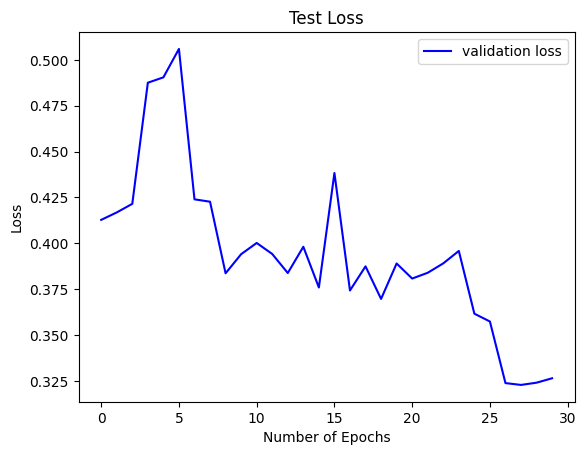

In [268]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(
    history.history['val_loss'],
    color='b',
    label="validation loss"
    )

# set plot title and axis labels
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()

# show plot
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


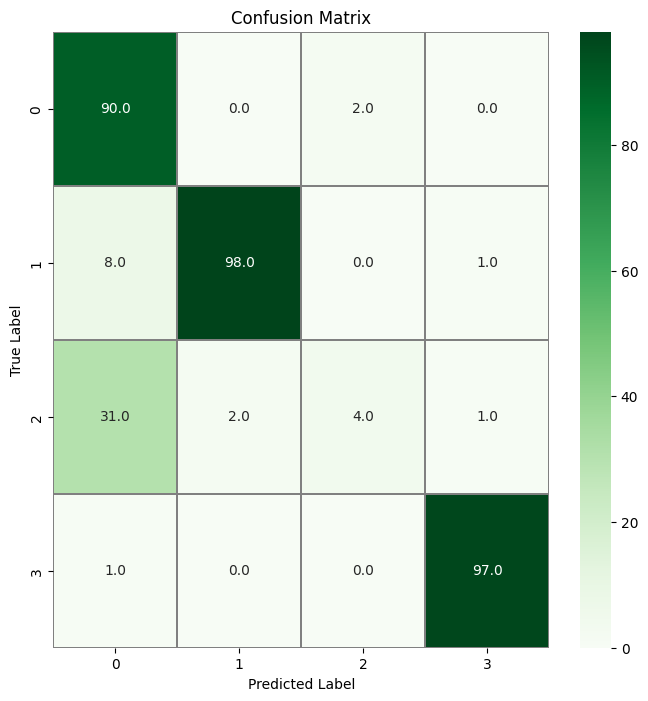

In [269]:
# confusion matrix

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# plot the confusion matrix
f: matplotlib.figure.Figure; ax: plt.Axes
f, ax = plt.subplots(figsize=(8, 8))

# generate confusion matrix as heatmap
sns.heatmap(
    confusion_mtx,
    annot=True,
    linewidths=0.01,
    cmap="Greens",
    linecolor="gray",
    fmt='.1f',
    ax=ax)

# set title and axis labels of confusion matrix
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# show confusion matrix
plt.show()